In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0


In [2]:
import numpy as np
from torcheeg.datasets import NumpyDataset, MNEDataset
from torcheeg import transforms
from torcheeg.transforms.pyg import ToG
from matplotlib import pyplot as plt
from utils_hugo import read_subject_epochs

In [3]:
adj = np.load('../utils/electrodes_adj.npy')

In [4]:
bids_dir = "/Users/hugofluhr/DATA/ds003505/"
epochs, y = read_subject_epochs(bids_dir=bids_dir, subject='sub-01', tmin=0)
metadata_list = [{'event': i} for i in y]

/Users/hugofluhr/Documents/Cours/NML/NetworkMachineLearning_2023/notebooks_hugo/utils_hugo.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(


Applying baseline correction (mode: mean)
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [10]:
epochs.get_data().shape

(588, 128, 126)

In [12]:
dataset = MNEDataset(epochs_list=[epochs[i] for i in range(len(epochs))],
                        metadata_list=metadata_list,
                        io_path='data/data_mne',
                        #offline_transform=transforms.BandPowerSpectralDensity(sampling_rate=250),
                        offline_transform=transforms.Downsample(num_points=42),
                        online_transform=transforms.ToTensor(),
                        label_transform=transforms.Compose([
                            transforms.Select('event')
                        ]),
                        num_worker=1)

[MNE]:  40%|███▉      | 233/588 [00:02<00:03, 116.09it/s]

The current io_size is not enough, and double the LMDB map size to 20971520 automatically.


[MNE]:  74%|███████▍  | 438/588 [00:03<00:01, 128.71it/s]

The current io_size is not enough, and double the LMDB map size to 41943040 automatically.


[MNE]: 100%|██████████| 588/588 [00:05<00:00, 113.34it/s]

Please wait for the writing process to complete...


# TorchEEG GNN

In [13]:
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv
from torch import nn
import torch
from torch.nn import functional as F

class GNN(nn.Module):
    def __init__(self, in_channels=4, hid_channels=64, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hid_channels)

        self.lin1 = nn.Linear(hid_channels, hid_channels)
        self.lin2 = nn.Linear(hid_channels, num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()

        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [14]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    loss_run = 0
    for batch_idx, batch in enumerate(dataloader):
        X = batch[0].to(device)
        y = batch[1].to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_run += loss.item()
        #if batch_idx % 10 == 0:
        #    loss, current = loss.item(), batch_idx * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_run/num_batches


def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            X = batch[0].to(device)
            y = batch[1].to(device)

            pred = model(X)
            #print('y : ', y)
            #print('pred : ', pred.argmax(1))
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    return val_loss, correct
    #if batch_idx % 10 == 0:
     #   print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

In [16]:
from torcheeg import model_selection
train_dataset, test_dataset = model_selection.train_test_split(dataset, shuffle=True)

In [17]:
class Linear(nn.Module):
    def __init__(self, in_channels = 4*128):
        super().__init__()
        self.in_channels = in_channels
        self.layers = nn.Sequential(
        nn.Linear(in_channels, 2),
        nn.Sigmoid()
        )

    def forward(self, data):
        #x=data.x.view(-1, self.in_channels)  # only using node features (x)
        x = data.view(-1, self.in_channels)
        output = self.layers(x)

        return output

In [51]:
class MLP(nn.Module):
    def __init__(self, in_channels = 4*128):
        super().__init__()
        self.in_channels = in_channels
        self.layers = nn.Sequential(
        nn.Linear(in_channels, 2),
        nn.ReLU(),
        nn.Linear(2,2),
        nn.Sigmoid()
        )

    def forward(self, data):
        #x=data.x.view(-1, self.in_channels)  # only using node features (x)
        x = data.view(-1, self.in_channels)
        output = self.layers(x)

        return output

In [52]:
print("Class balance in train dataset : {:.1f}%".format(100*np.sum([l[1] for l in train_dataset])/len(train_dataset)))
print("Class balance in test dataset : {:.1f}%".format(100*np.sum([l[1] for l in test_dataset])/len(test_dataset)))

Class balance in train dataset : 50.9%
Class balance in test dataset : 46.6%


In [53]:
print("Nb of features per electrode : {}".format(dataset[0][0].shape[1]))

Nb of features per electrode : 42


In [59]:
from torch_geometric.loader import DataLoader

#model = GNN(in_channels=125).to(device)
model = MLP(in_channels=128*42).to(device)
print(' ----- Current Model : -----')
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 300
train_losses, val_losses = [], []
train_acc, val_acc = [], []
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    val_loss, correct = valid(val_loader, model, loss_fn)
    val_losses.append(val_loss)
    _, correct_train = valid(train_loader, model, loss_fn)
    train_acc.append(correct_train)
    val_acc.append(correct)

    if t % 10 == 0:
        print(f"EPOCH : {t:3d} | train Loss : {train_loss:.3f} | val loss : {val_loss:.3f} | Acc_train : {100*correct_train:.2f} %| Acc_test : {100*correct:.2f} %")
print("Done!")

 ----- Current Model : -----
MLP(
  (layers): Sequential(
    (0): Linear(in_features=5376, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
  )
)
EPOCH :   0 | train Loss : 0.693 | val loss : 0.699 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  10 | train Loss : 0.694 | val loss : 0.699 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  20 | train Loss : 0.693 | val loss : 0.699 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  30 | train Loss : 0.694 | val loss : 0.699 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  40 | train Loss : 0.693 | val loss : 0.699 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  50 | train Loss : 0.693 | val loss : 0.698 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  60 | train Loss : 0.694 | val loss : 0.698 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  70 | train Loss : 0.694 | val loss : 0.698 | Acc_train : 50.85 %| Acc_test : 46.61 %
EPOCH :  80 | train Loss : 0.6

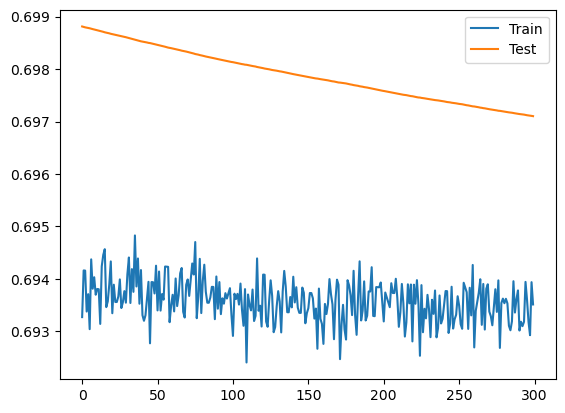

In [60]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train', 'Test'])

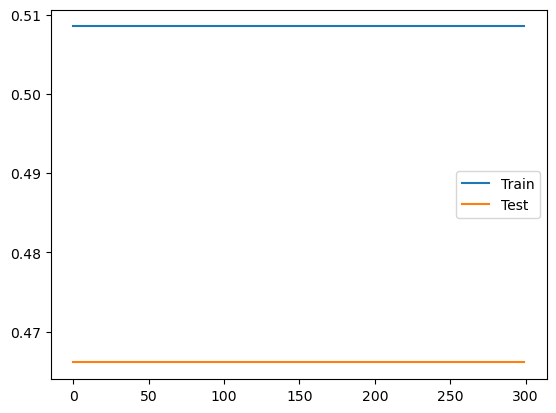

In [58]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train', 'Test'])

# Model from PyG tuto

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# params
num_features = 4
num_classes = 2

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        #self.logsigmoid = nn.LogSigmoid()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #x = self.logsigmoid(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

In [ ]:
from torcheeg import model_selection
from torch_geometric.loader import DataLoader

train_dataset, test_dataset = model_selection.train_test_split(dataset)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train_tuto():
    model.train()
    loss_run = 0
    num_batches = len(train_loader)
    for data in train_loader:  # Iterate in batches over the training dataset.
         X = data[0].to(device)
         y = data[1].to(device)
         out = model(X.x, X.edge_index, X.batch)  # Perform a single forward pass.
         loss = criterion(out, y)  # Compute the loss.
         loss_run +=loss.item()
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    
    return loss_run/num_batches

def test_tuto(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         X = data[0].to(device)
         y = data[1].to(device)
         out = model(X.x, X.edge_index, X.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 2):
    loss = train_tuto()
    train_acc = test_tuto(train_loader)
    test_acc = test_tuto(test_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

# Looking at the data

In [ ]:
samples = [elem[0].x for elem in list(dataset_psd)]
labels = [elem[1] for elem in list(dataset_psd)]

# LIN Model

In [ ]:
class LIN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lin = nn.Linear(input_size, 2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.lin(x)
        x = self.sig(x)
        return x 

In [ ]:
LIN_model = LIN(625*128).to(device)

In [ ]:
train_loader_lin = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader_lin = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
train_dataset_psd, test_dataset_psd = model_selection.train_test_split(dataset_psd)


In [ ]:
def train_lin(loader):
    LIN_model.train()
    loss_run = 0
    num_batches = len(loader)
    for data in loader:  # Iterate in batches over the training dataset.
         X = data[0].to(device)
         y = data[1].to(device)
         print('x : ', X.x.shape)
         out = LIN_model(X.x.reshape())  # Perform a single forward pass.
         #print('out : ', out.shape)
         #print('y : ', y.shape)
         break
         loss = criterion(out, y)  # Compute the loss.
         loss_run +=loss.item()
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
    
    return loss_run/num_batches

def test_lin(loader):
     LIN_model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         X = data[0].to(device)
         y = data[1].to(device)
         out = LIN_model(X.x.flatten())  
         #print('out : ', out.shape)
         out = out.reshape((1,-1))
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    loss = train_lin(train_loader_lin)
    train_acc = test_lin(train_loader_lin)
    test_acc = test_lin(test_loader_lin)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Loss: {loss:.4f}')

# Training over 1 or 2 samples to debug models

In [ ]:
from torcheeg import model_selection
from torch_geometric.loader import DataLoader

train_dataset, test_dataset = model_selection.train_test_split(dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
mini_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

In [ ]:
two_samples = next(iter(mini_loader))
two_samples

In [ ]:
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
epochs = 500

losses = []
for epoch in range(epochs):
    model.train()

    X = two_samples[0].to(device)
    y = two_samples[1].to(device)
    out = model(X.x, X.edge_index, X.batch)  # Perform a single forward pass.
    loss = criterion(out, y)  # Compute the loss.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.

    losses.append(loss.item())

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5000

losses = []
for epoch in range(epochs):
    model.train()

    X = two_samples[0].to(device)
    y = two_samples[1].to(device)
    out = model(X)  # Perform a single forward pass.
    loss = criterion(out, y)  # Compute the loss.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    optimizer.zero_grad()  # Clear gradients.

    losses.append(loss.item())

In [ ]:
plt.plot(losses)